### Мусин Камиль
## Домашнее Задание 2

Требуется библиотека simhash
Файл script-hw2.py код из данного нотебука
simhash_count.py - подсчет simhash для статей

SimHash считается по триграммам текста, по методу прибавления +/-1

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import sys
from collections import deque

In [2]:
class HTMLPage:
    def __init__(self, url):
        self.edges_out = set()
        self.edges_in = set()
        self.url = url
        self.dist = -1
        self.pagerank = 0

class WebGraph:
    def __init__(self):
        self.pages = []

    def read(self, urlsfilename="urls_pp.txt", graphfilename="graph_pp.txt"):
        with open(urlsfilename) as urlsfile:
            with open(graphfilename) as graphfile:
                for line in urlsfile:
                    edges = [int(x) for x in graphfile.readline().rstrip().split()[1:]]
                    index, url = line.split()
                    index = int(index)
                    self.add_page(url, edges)
                    if index % 100 == 0:
                        sys.stdout.write("\r{0} pages read".format(index))
        sys.stdout.write("\n")

    def read_ranks(self, ranksfilename="ranks.txt"):
        with open(ranksfilename) as ranksfile:
            for line in ranksfile:
                index, rank = line.split('\t', 1)
                index = int(index)
                rank = float(rank)
                self.pages[index].pagerank = rank

                
    def read_hashes(self, filename="hashes.txt"):
        with open(filename) as hashfile:
            for line in hashfile:
                index, h = line.split('\t', 1)
                index = int(index)
                h = int(h)
                self.pages[index].simhash = h
    
    def add_page(self, url, edges):
        self.pages.append(HTMLPage(url))
        self.pages[-1].edges_out = set(edges)
        
    def count_in_edges(self):
        for index, page in enumerate(self.pages):
            for edge in page.edges_out:
                self.pages[edge].edges_in.add(index)
                
    def calculate_distances(self):
        q = deque([0])
        self.pages[0].dist = 0
        while len(q) != 0:
            vertex = q.popleft()
            for edge in self.pages[vertex].edges_out:
                if self.pages[edge].dist == -1:
                    self.pages[edge].dist = self.pages[vertex].dist + 1
                    q.append(edge)

    def write_urls(self, filename="urls_pp.txt"):
        with open(filename, "w", encoding="utf-8") as f:
            for i in range(len(self.pages)):
                f.write("{0}\t{1}\n".format(i, self.pages[i].url))

    def write_graph(self, filename="graph_pp.txt"):
        with open(filename, "w", encoding="utf-8") as f:
            for i in range(len(self.pages)):
                f.write("{0}\t{1}\n".format(i, " ".join(str(x) for x in self.pages[i].edges_out)))

    def write_ranks(self, filename="ranks.txt"):
        with open(filename, "w", encoding="utf-8") as f:
            for i in range(len(self.pages)):
                f.write("{0}\t{1}\n".format(i, self.pages[i].pagerank))
                
    def write_hashes(self, filename="hashes.txt"):
        with open(filename, "w", encoding="utf-8") as f:
            for i in range(len(self.pages)):
                f.write("{0}\t{1}\n".format(i, self.pages[i].simhash))

In [3]:
graph = WebGraph()
graph.read()
graph.read_ranks()
graph.read_hashes()

145100 pages read


In [8]:
class PageHash:
    def __init__(self, index, h):
        self.index = index
        self.h = h
        self.onebits = bin(h).count('1')
        self.group = index

hashes = [PageHash(index, page.simhash) for index, page in enumerate(graph.pages)]

In [9]:
hashes.sort(key=lambda x: x.onebits)

# Нахождение групп полудубликатов

Единственная используемая оптимизация: Я упорядочил группы по возрастанию кол-ва ненулевых бит в хеше, сравнивал только те пары статей, у которых разница в этом значение меньше N=5, 10, 15

Главный элементом в группе считается статья с наибольшим PageRank

In [19]:
def findgroups(hashes, difference, dists = None):
    if dists is None:
        dists = []
    for pagehash in hashes:
        pagehash.group = pagehash.index
    left = 0
    current = 0
    for current in range(len(hashes)):
        sys.stdout.write("\rProcessing {0}".format(current))
        while hashes[left].onebits < hashes[current].onebits - difference:
            left += 1
        for i in range(left, current):
            diff = bin(hashes[current].h ^ hashes[i].h).count('1')
            if diff in dists:
                dists[diff] += 1
            else:
                dists[diff] = 1
            if (diff <= difference):
                hashes[current].group = hashes[i].group
                break
    groups = dict()
    for page_hash in hashes:
        if page_hash.group in groups:
            groups[page_hash.group].append(page_hash.index)
        else:
            groups[page_hash.group] = [page_hash.index]
    return groups
    

## N = 5

In [11]:
dists = dict()
groups = findgroups(hashes, 5, dists)

### График размеров групп

Group sizes hist diff=5


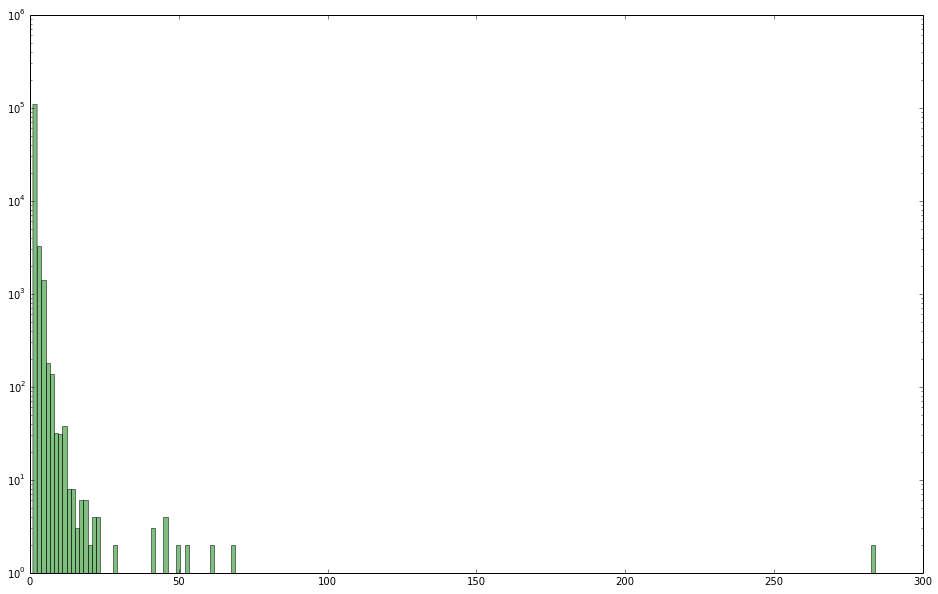

In [13]:
group_sizes = [len(x) for x in groups.values()]
print("Group sizes hist diff=5")
plt.figure(figsize=(16, 10))
n, bins, patches = plt.hist(group_sizes, 200, facecolor='green', alpha=0.5)
plt.yscale("log", nonposy='clip')
plt.show()

### Top10 по размеру групп

In [15]:
grouplist = list(groups.items())
grouplist.sort(key=lambda x: -len(x[1]))
for group in grouplist[:10]:
    main = max((graph.pages[page].pagerank, graph.pages[page].url) for page in group[1])[1]
    print(main, len(group[1]))

https://simple.wikipedia.org/wiki/M%C3%A9rignac,_Gironde 284
https://simple.wikipedia.org/wiki/Navarrenx 284
https://simple.wikipedia.org/wiki/Foreste 279
https://simple.wikipedia.org/wiki/.eu 255
https://simple.wikipedia.org/wiki/Saint-Omer 239
https://simple.wikipedia.org/wiki/Romans,_Ain 172
https://simple.wikipedia.org/wiki/Pope_John_XXII 138
https://simple.wikipedia.org/wiki/Vezot 104
https://simple.wikipedia.org/wiki/Boulogne,_Vend%C3%A9e 93
https://simple.wikipedia.org/wiki/Th%C3%A9rouanne 88


### Распределение расстояний между сравниваемыми статьями

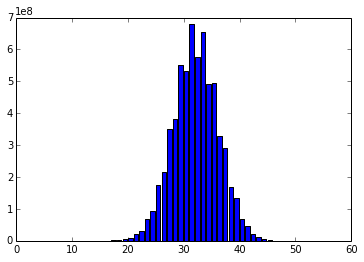

In [17]:
xy = list(dists.items())
X = [x for x, y in xy]
Y = [y for x, y in xy]
plt.bar(X, Y)
plt.show()

## N = 10

In [21]:
dists = dict()
groups = findgroups(hashes, 10, dists)

Processing 145150

### График размеров групп

Group sizes hist diff=10


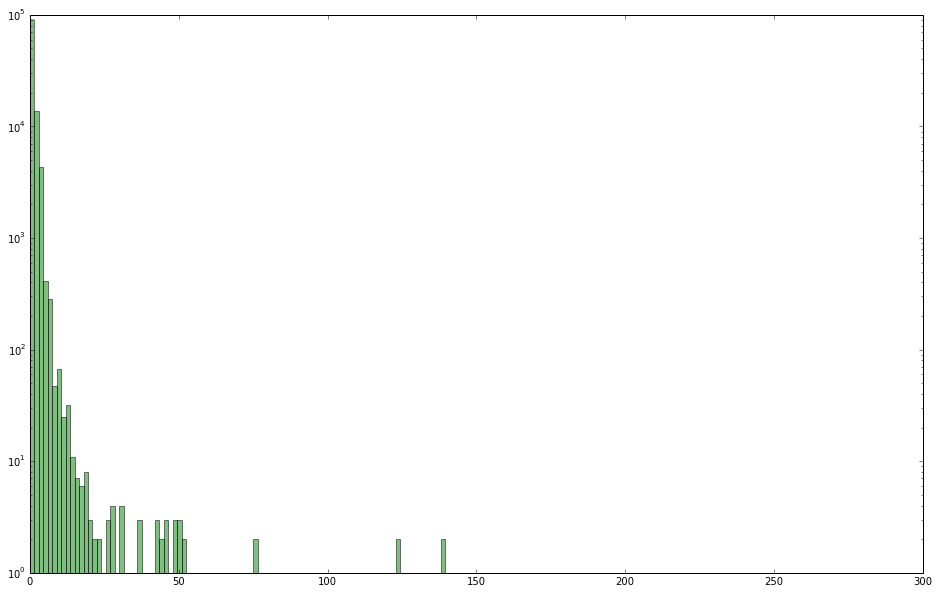

In [23]:
group_sizes = [len(x) for x in groups.values()]
print("Group sizes hist diff=10")
plt.figure(figsize=(16, 10))
n, bins, patches = plt.hist(group_sizes, 200, facecolor='green', alpha=0.5, range=(0,300))
plt.yscale("log", nonposy='clip')
plt.show()

### Top10 по размеру групп

In [24]:
grouplist = list(groups.items())
grouplist.sort(key=lambda x: -len(x[1]))
for group in grouplist[:10]:
    main = max((graph.pages[page].pagerank, graph.pages[page].url) for page in group[1])[1]
    print(main, len(group[1]))

https://simple.wikipedia.org/wiki/Saint-Quentin,_Aisne 617
https://simple.wikipedia.org/wiki/Cowboy 468
https://simple.wikipedia.org/wiki/Navarrenx 444
https://simple.wikipedia.org/wiki/Matlock,_Iowa 376
https://simple.wikipedia.org/wiki/Le_Bouchaud 262
https://simple.wikipedia.org/wiki/.eu 255
https://simple.wikipedia.org/wiki/Romans,_Ain 233
https://simple.wikipedia.org/wiki/Yzeure 222
https://simple.wikipedia.org/wiki/Saint-Mal%C3%B4-du-Bois 217
https://simple.wikipedia.org/wiki/Ch%C3%A2teau-Gontier 213


### Распределение расстояний между сравниваемыми статьями

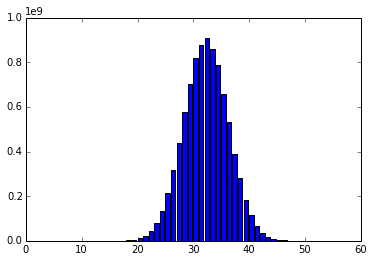

In [25]:
xy = list(dists.items())
X = [x for x, y in xy]
Y = [y for x, y in xy]
plt.bar(X, Y)
plt.show()

## N = 15

In [27]:
dists = dict()
groups = findgroups(hashes, 15, dists)

Processing 145150

### График размеров групп

Group sizes hist diff=10


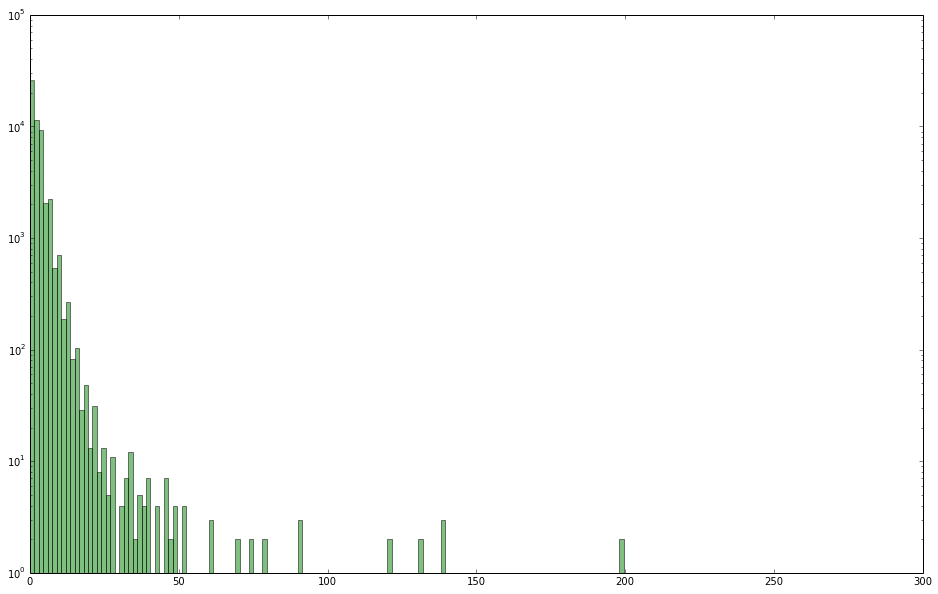

In [28]:
group_sizes = [len(x) for x in groups.values()]
print("Group sizes hist diff=10")
plt.figure(figsize=(16, 10))
n, bins, patches = plt.hist(group_sizes, 200, facecolor='green', alpha=0.5, range=(0,300))
plt.yscale("log", nonposy='clip')
plt.show()

### Top10 по размеру групп

In [29]:
grouplist = list(groups.items())
grouplist.sort(key=lambda x: -len(x[1]))
for group in grouplist[:10]:
    main = max((graph.pages[page].pagerank, graph.pages[page].url) for page in group[1])[1]
    print(main, len(group[1]))

https://simple.wikipedia.org/wiki/Islam 1639
https://simple.wikipedia.org/wiki/Similar 1508
https://simple.wikipedia.org/wiki/Barack_Obama 968
https://simple.wikipedia.org/wiki/Romance_languages 891
https://simple.wikipedia.org/wiki/Programming_language 865
https://simple.wikipedia.org/wiki/Racing 620
https://simple.wikipedia.org/wiki/Railway 445
https://simple.wikipedia.org/wiki/Pornography 435
https://simple.wikipedia.org/wiki/Acronym 386
https://simple.wikipedia.org/wiki/Television_network 383


### Распределение расстояний между сравниваемыми статьями

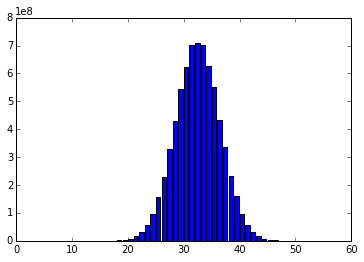

In [30]:
xy = list(dists.items())
X = [x for x, y in xy]
Y = [y for x, y in xy]
plt.bar(X, Y)
plt.show()

## Вывод

Оказалось, что на стадии обхода Википедии, для некоторых страниц не был обнаружен редирект. Поэтому в коллекции присутствуют полные дубли. Из них собственно и состоят группы при N = 5. Также статьи имеющие много общих слов попадают в одну группы, но таких давольно мало.

При N = 10, статьи сильно пересекающиеся по набору слов , начинают попадать в одну группу. Данное значение можно использовать для поиска неточных дубликатов, хотя некоторые образовавшиеся группы слишком велики, и включают в себя "далекие" статьи

При N = 15, в группах часто начинают оказываться совсем не близкие статьи. Разрешать отличие в 20% сигнатуры, неприемлимо для поиска дубликатов.